# Import des packages nécessaires

In [4]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib
import datetime
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Récupération des fonctions des autres notebooks et des dataset

In [2]:
#Entree par l'utilisateur de info sur son domicile 
dep = (input("Code departement (ex : 75)"))
num = int(input("Numero"))
nom_voie = input("Nom de la voie")
ville = input('Ville')
code_postal = input("Code postal")

Code departement (ex : 75)44
Numero4
Nom de la voieRue Fouré
VilleNantes
Code postal44000


In [3]:
import levenstein

In [4]:
def addresse_to_GPS(dep, num, nom_voie, ville, code_postal):
    adresses_dep = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False) #recuperation des adresses postales correspondant au département de l'utilisateur
    #Correction de l'ortographe de la ville et de la rue (si necessaire) pour que cela fit au mieux avec le dataframe
    #On utilise pour cela la minimisation de la distance de Levenstein
    
    ville=levenstein.get_ville_correct(ville,adresses_dep) 
    nom_voie=levenstein.get_rue_corect(nom_voie,adresses_dep)

    foyer_infos = adresses_dep[(adresses_dep["numero"] == num) & (adresses_dep["nom_commune"] == ville) & (adresses_dep["nom_voie"] == nom_voie)] 
    foyer = foyer_infos.to_numpy()
    foyer = foyer.tolist()

    
    longitude = foyer[0][12]
    latitude = foyer[0][13]

    return(longitude, latitude, ville, nom_voie)

In [5]:
long, lat, ville, nom_voie = addresse_to_GPS(dep, num, nom_voie, ville, code_postal) #On corrige au passage l'addresse
long, lat

(-1.546307, 47.214242)

# Nucléaire 

### Récupération des tables de données

In [6]:
centrales = pd.read_csv("DataSets/centrales_nucleaires.csv",sep=',',encoding_errors='ignore')

In [7]:
import Nucleaire

In [8]:
rNu = Nucleaire.nucleaire(long, lat, centrales)
rNu

La centrale nucleaire la plus proche se situe à :
9979.717702772043 Fessenheim
Le risque nucléaire à cette adresse est de :


5

# Inondations

### Récupération des tables de données

In [9]:
df_risque_inond=gpd.read_file("DataSets/Inondation//n_carte_inond_s.shp") 
df_adresses = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False)

In [10]:
import inondation

In [11]:
adresse_gpd=inondation.adresse_to_gpd(df_adresses)
rIn=inondation.adresse_to_risque(dep,num,nom_voie,ville,code_postal)

NameError: name 'gpd_adresses' is not defined

# Glissement de terrains

### Récupération des tables de données

In [ ]:
df_mvtTerrains13 = pd.read_csv("DataSets/mouvement_terrain_13.csv", sep = ";")
df_mvtTerrains31 = pd.read_csv("DataSets/mouvement_terrain_31.csv", sep = ";")
df_mvtTerrains44 = pd.read_csv("DataSets/mouvement_terrain_44.csv", sep = ";")

### Import des fonctions

In [ ]:
import glissement_terrain

In [ ]:
long, lat = addresse_to_GPS(dep, num, nom_voie, ville, code_postal)

In [ ]:
dico = glissement_terrain.event_less_10km(lat, long, df_mvtTerrains44)
riGdT,quali_data= glissement_terrain.calcul_risque(dico)

# Secheresse

### Récupération des tables de données

In [ ]:
import secheresse

In [ ]:
rSe = secheresse.secheresse(dep, num, nom_voie, ville, code_postal) * 5

# Pollution

### Récupération des tables de données

In [ ]:
df_PM10 = pd.read_csv("DataSets/"+dep+"/PM10.csv", sep = ";")
df_SO2 = pd.read_csv("DataSets/"+dep+"/SO2.csv", sep = ";")
df_CO = pd.read_csv("DataSets/"+dep+"/CO.csv", sep = ";")

### code

In [ ]:
import Pollution

In [ ]:
rPol = Pollution.risque_polution(lat, long, df_CO, df_SO2, df_PM10)
rPol

# Temperature

### Récupération des tables de données

In [ ]:
df_temp13 = pd.read_csv("DataSets/temperature_"+dep+".csv", sep = ";")

### Code

In [ ]:
import temperature

In [ ]:
#On modifie les tables pour les rendre exploitables
df_temp13=temperature.preprocessing(df_temp13)

In [ ]:
#On vérifie que l'on a bien au moins une mesure par semaine dans nos tables (pour pouvoir fixer la saisonalité à 52)
temperature.test_saisonalité(df_temp13)

In [ ]:
#Temperature maximale journalière au cours du temps 
#On remarque une belle saisonalité annuelle, ce qui est particulièrement adapté dans le cadre d'une utilisation du model SARIMA
temperature.plot_temperature(df_temp13)

In [ ]:
#décomposition de la série temporelle en composante saisonnelle, tendance et en bruit
temperature.get_decomposition(df_temp13)

In [ ]:
#retourne les prédiction de temprérature pour un horizon donné, les paramètres du model sont pré rentrés. 
#model entrainé entre 2010 et 2019 et testé sur 2019, 2020, 2021, mi 2022
pred, pred_ci=temperature.get_prediction_graph(2030,df_temp13)

In [ ]:
Te = temperature.temperature_max(pred,pred_ci)

In [ ]:
rTe = (Te / 50) * 20
rTe

# Code principal

In [ ]:
vec_risque = [rNu, rPol, rSe, rTe, riGdT, rIn]

In [ ]:
note_final = sum(vec_risque)
note_final

In [10]:
#vect_graph = [elem/20 for i in vect_risque]
vect_graph = [0.9, 0.5, 0.7, 0.8, 0.6, 0.4]

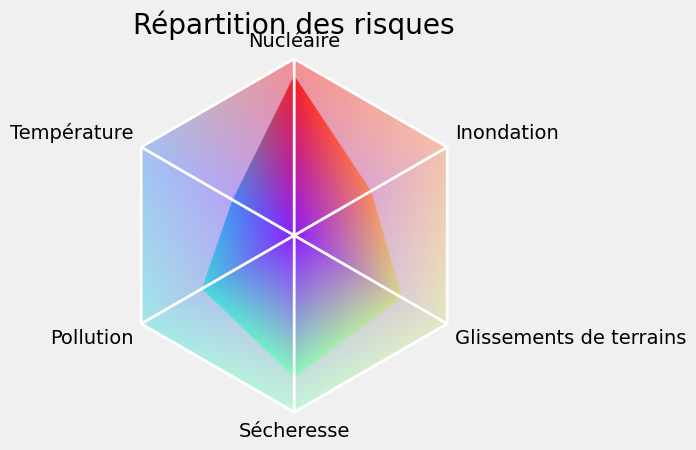

In [11]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

proportions = vect_graph
labels = ['Nucléaire', 'Inondation', 'Glissements de terrains', 'Sécheresse', 'Pollution', 'Température']
N = len(proportions)
proportions = np.append(proportions, 1)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
x = np.append(np.sin(theta), 0)
y = np.append(np.cos(theta), 0)
triangles = [[N, i, (i + 1) % N] for i in range(N)]
triang_backgr = tri.Triangulation(x, y, triangles)
triang_foregr = tri.Triangulation(x * proportions, y * proportions, triangles)
cmap = plt.cm.rainbow_r  # or plt.cm.hsv ?
colors = np.linspace(0, 1, N + 1)
plt.tripcolor(triang_backgr, colors, cmap=cmap, shading='gouraud', alpha=0.4)
plt.tripcolor(triang_foregr, colors, cmap=cmap, shading='gouraud', alpha=0.8)
plt.triplot(triang_backgr, color='white', lw=2)
for label, color, xi, yi in zip(labels, colors, x, y):
    plt.text(xi * 1.05, yi * 1.05, label,  # color=cmap(color),
             ha='left' if xi > 0.1 else 'right' if xi < -0.1 else 'center',
             va='bottom' if yi > 0.1 else 'top' if yi < -0.1 else 'center')
plt.axis('off')
plt.gca().set_aspect('equal')
plt.title("Répartition des risques")
plt.show()
